In [1]:
from datasets import load_dataset
ds = load_dataset("uoft-cs/cifar10")


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch as t
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from datasets import load_dataset
import torch.nn.functional as F
import seaborn as sns


In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [4]:
transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1), 
        transforms.Resize((32, 32)),                  
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]) 
])

def preprocess(example):
    example["img"] = [transform(img) for img in example["img"]]
    return example

ds = ds.with_transform(preprocess)


In [5]:
train_loader = DataLoader(ds["train"], batch_size=32, shuffle=True)
test_loader  = DataLoader(ds["test"], batch_size=32)
seen=set()
for batch in train_loader:
    X, y = batch["img"], batch["label"]
    seen.add(y[0].item())
seen

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  
        out = F.relu(out)
        return out
    
    
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Sequential(nn.Linear(256, num_classes),
                                )
    
    def _make_layer(self, block, out_channels, blocks, stride):
        layers = []

        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = (self.fc1(out))
        return out


In [7]:
device = t.device("mps" if t.backends.mps.is_available() else "cpu")
print("Using device:", device)

model = ResNet(ResidualBlock,[2,2,2],10).to(device)
createrion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())


Using device: mps


In [8]:
import os,cv2 as cv
def test():
    lab = ['aeroplane','automobile','bird','catt','deer','dog','frog','horse','ship','truck']
    correct = 0
    total = 0
    with t.no_grad():
        for filename in os.listdir("/Users/bhara-zstch1566/CNN/Project/CIFRA 10"):
            if filename=="model" or filename==".DS_Store":
                continue
            x=cv.imread("/Users/bhara-zstch1566/CNN/Project/CIFRA 10/"+filename)
            
            transform = transforms.Compose([
        transforms.ToPILImage(),                   
        transforms.Grayscale(num_output_channels=1), 
        transforms.Resize((32, 32)),                  
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]) 
    ])

            x = transform(x)
            x=x.unsqueeze(0)
            x = x.to(device)

            ypred = model(x)
            _, predicted = t.max(ypred.data, 1)
            total+=1
            correct+=lab[predicted]==filename.split('.')[0]
            
    return (correct/total*100)


In [9]:
acc = []
cost = []
test_acc = []

In [10]:
def cnn(epochs):
    for epoch in range(epochs):
        running_loss = 0.0
        
        for batch in train_loader:
            img, label = batch["img"].to(device), batch["label"].to(device)
            
            ypred = model(img)
            loss = createrion(ypred, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{5}], Loss: {running_loss / len(train_loader):.4f}")
        acc.append(test())
        cost.append(running_loss / len(train_loader))

        correct = 0
        total = 0
        with t.no_grad():

            for batch in test_loader:
                img, label = batch["img"].to(device), batch["label"].to(device)
                ypred = model(img)
                _, predicted = t.max(ypred.data, 1)
                total += label.size(0)
                correct += (predicted == label).sum().item()

            test_acc.append(correct/total*100)
            print(correct/total*100)
        if test() >=85:
            return 


In [11]:
cnn(20)

Epoch [1/5], Loss: 1.3814
61.980000000000004
Epoch [2/5], Loss: 0.9863
66.45
Epoch [3/5], Loss: 0.8068
71.06
Epoch [4/5], Loss: 0.6748
72.56
Epoch [5/5], Loss: 0.5572
73.50999999999999
Epoch [6/5], Loss: 0.4378
73.53
Epoch [7/5], Loss: 0.3397
73.77


In [12]:
correct = 0
total = 0
with t.no_grad():

    for batch in test_loader:
        img, label = batch["img"].to(device), batch["label"].to(device)
        ypred = model(img)
        _, predicted = t.max(ypred.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

print(f"Accuracy: {(correct/total*100):.4f}")

Accuracy: 73.7700


In [13]:
import cv2 as cv

x=cv.imread("/Users/bhara-zstch1566/CNN/Project/CIFRA 10/car.jpeg")

[ WARN:0@132.108] global loadsave.cpp:275 findDecoder imread_('/Users/bhara-zstch1566/CNN/Project/CIFRA 10/car.jpeg'): can't open/read file: check file path/integrity


deer ---- True
aeroplane ---- True
frog ---- True
catt ---- True
automobile ---- True
dog ---- True
truck ---- True
bird ---- False
horse ---- True
ship ---- True

Accuracy: 90.0000


[60.0, 60.0, 80.0, 70.0, 80.0, 80.0, 90.0]

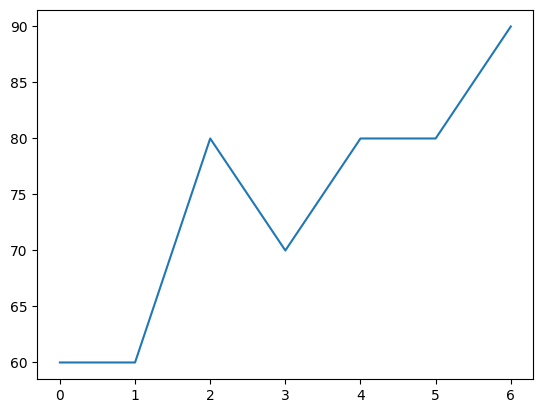

In [14]:

import os,cv2 as cv
def test():
    lab = ['aeroplane','automobile','bird','catt','deer','dog','frog','horse','ship','truck']
    correct = 0
    total = 0
    with t.no_grad():
        for filename in os.listdir("/Users/bhara-zstch1566/CNN/Project/CIFRA 10"):
            if filename=="model" or filename==".DS_Store":
                continue
            x=cv.imread("/Users/bhara-zstch1566/CNN/Project/CIFRA 10/"+filename)
            
            transform = transforms.Compose([
        transforms.ToPILImage(),                   
        transforms.Grayscale(num_output_channels=1),  
        transforms.Resize((32, 32)),                 
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]) 
    ])

            x = transform(x)
            x=x.unsqueeze(0)
            x = x.to(device)

            ypred = model(x)
            _, predicted = t.max(ypred.data, 1)
            print(f"{filename.split('.')[0]} ---- {lab[predicted]==filename.split('.')[0]}")
            total+=1
            correct+=lab[predicted]==filename.split('.')[0]
            
    return ((correct/total*100))
print(f"\nAccuracy: {test():.4f}")
sns.lineplot((acc))
acc

<Axes: >

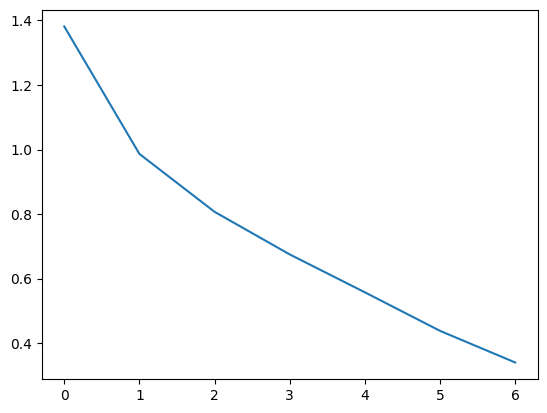

In [15]:
sns.lineplot((cost))

<Axes: >

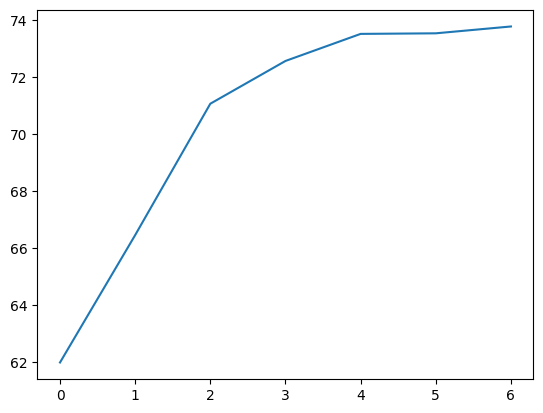

In [16]:
sns.lineplot(test_acc)

In [17]:
t.save(model.state_dict(), "model.pth")